This notebook adapts https://seurat-notebook-image.readthedocs.io/en/latest/examples/seurat_pbmc_v0.0.1.html

## **Setup**

**Only run this setup section on google colab, do not run this code if you use this notebook in a different environment.**

In this section, we will setup all the computing environment to allow you to run the analyses needed for this part.

In [ ]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

loadPackages = function(pkgs){
  myrequire = function(...){
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(...))))
  }
  ok = sapply(pkgs, require, character.only=TRUE, quietly=TRUE)
  if (!all(ok)){
    message("There are missing packages: ", paste(pkgs[!ok], collapse=", "))
  }
}

## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")

45 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1).
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6p

Tracing function "install.packages" in package "utils"



In [ ]:
## Install the R packages
system("sudo apt install libgsl-dev")
system("sudo apt-get install libhdf5-dev")  # for hdf5r
cranPkgs2Install = c("BiocManager", "ggraph", "ggplot2", "clustree", "hdf5r")
install.packages(cranPkgs2Install, ask=FALSE, update=TRUE, quietly=FALSE)
install.packages('Seurat')

In [ ]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    %||%, intersect, t



Attaching package: ‘Seurat’


The following object is masked from ‘package:base’:

    %||%




## Load count matrix

Download the tutorial data:

In [ ]:
system("cd /tmp;\
        wget -q http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz;\
        tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz")

Setup the Seurat Object:

In [ ]:
library(dplyr)
library(Seurat)
library(patchwork)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/tmp/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

You now have loaded the count matrix and some annotation and can work with it in this notebook!

In [ ]:
# Lets examine the dimensions of this count matrix: (genes x cells)
dim(pbmc.data)

[1] 32738  2700

In [ ]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

The . values in the matrix represent 0s (no molecules detected). Since most values in an scRNA-seq matrix are 0, Seurat uses a sparse-matrix representation whenever possible. This results in significant memory and speed savings for Drop-seq/inDrop/10x data.

## Quality control

Let's annotate the fraction of mitochondrial reads per cell:

In [ ]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [ ]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


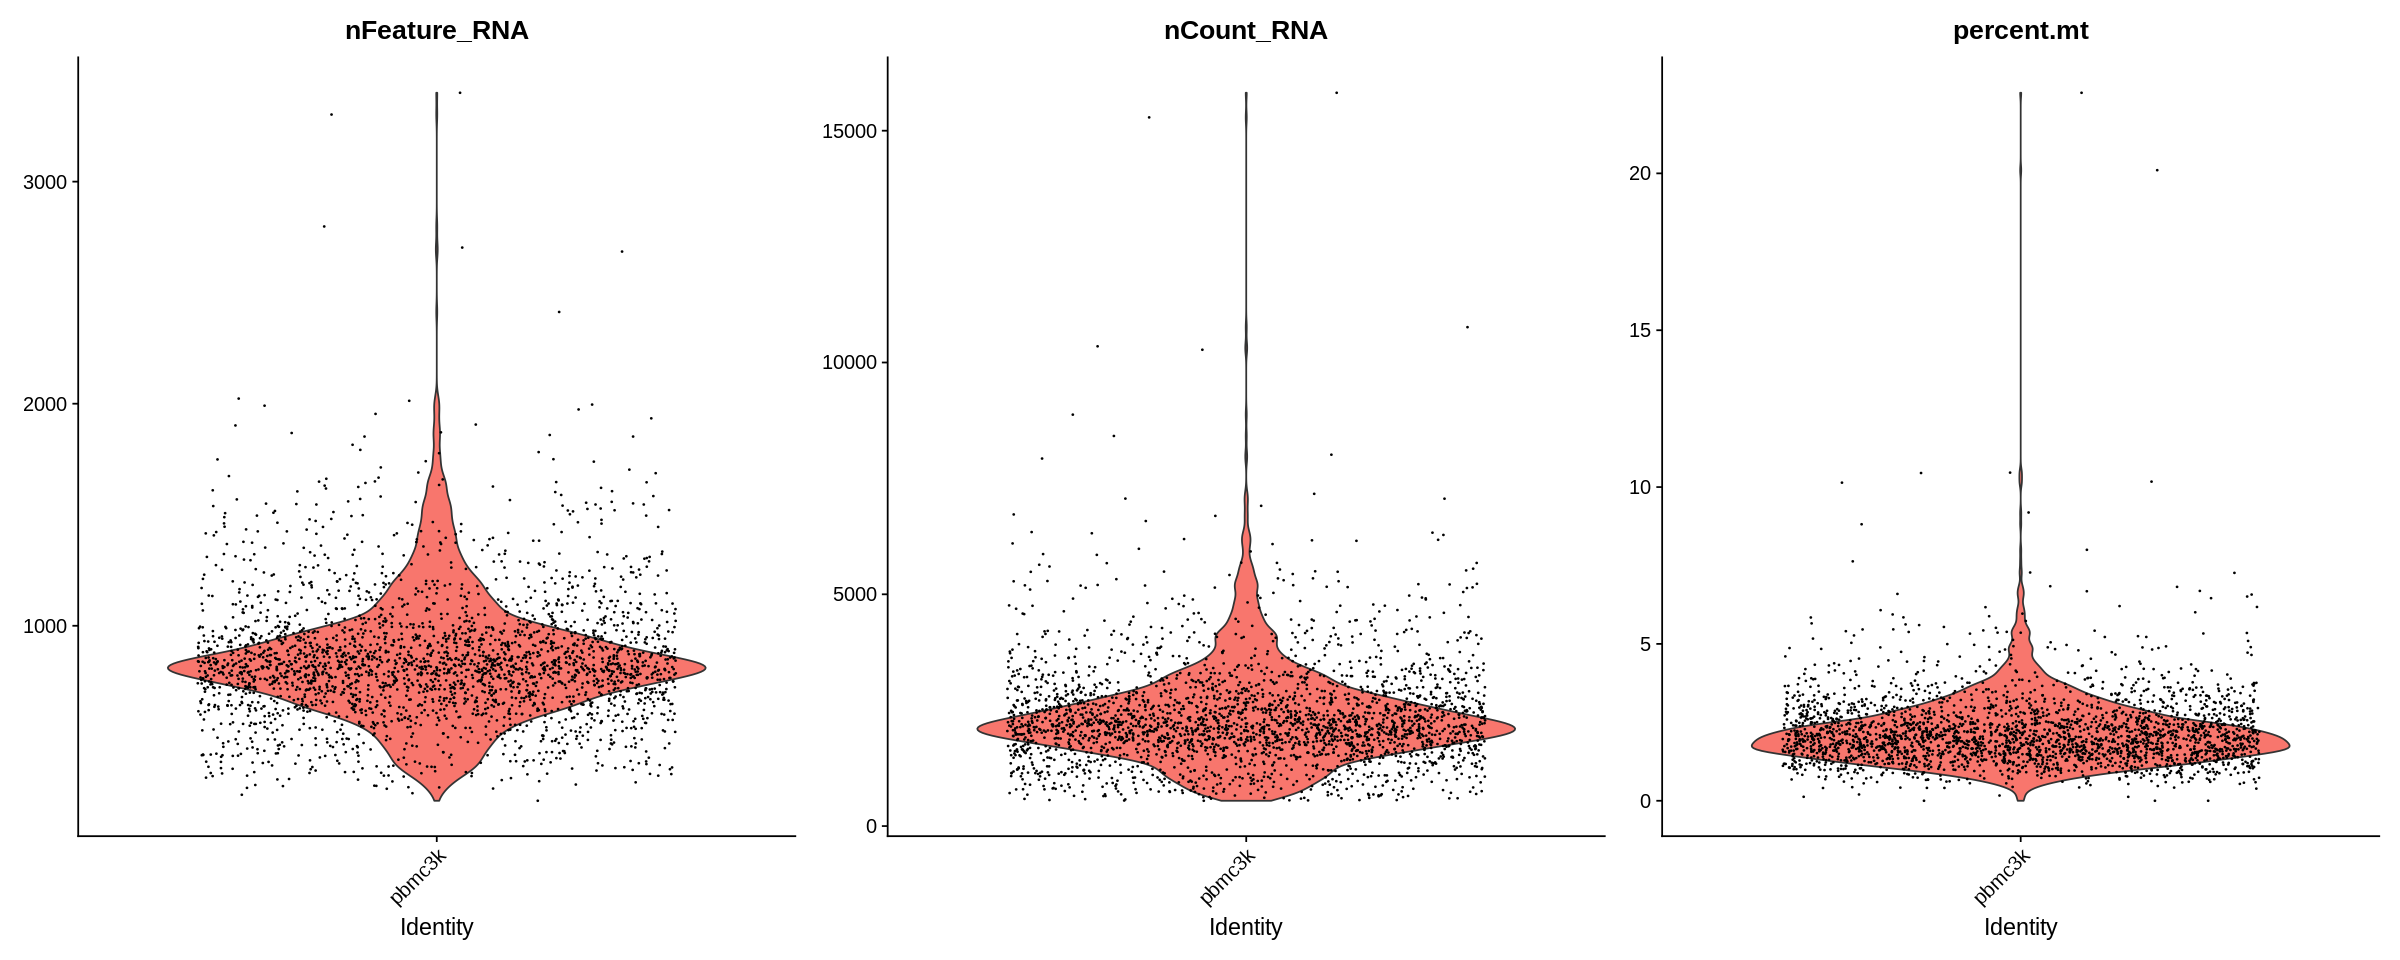

In [ ]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=20, repr.plot.height=8)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


Let's subset to cells that are high quality:


*   \> 200 expressed genes (avoid low quality cells)
*   \< 2500 UMI counts (avoid potential doublets)
*   \< 5 % fraction of mitochondrial UMIs (avoid stressed / low quality cells)


In [ ]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

In [ ]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [ ]:
pbmc <- NormalizeData(pbmc)

Normalizing layer: counts



##Identify variable genes

*The* first step is to identify the most variable genes across the dataset.
Genes that don't vary across cells probably won't contribute much to downstream analyses, so we will focus on the top 2000 most variable genes here.
First we will apply a variance stablizing transformation (vst) to model the mean/variance relationship

Finding variable features for layer counts

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


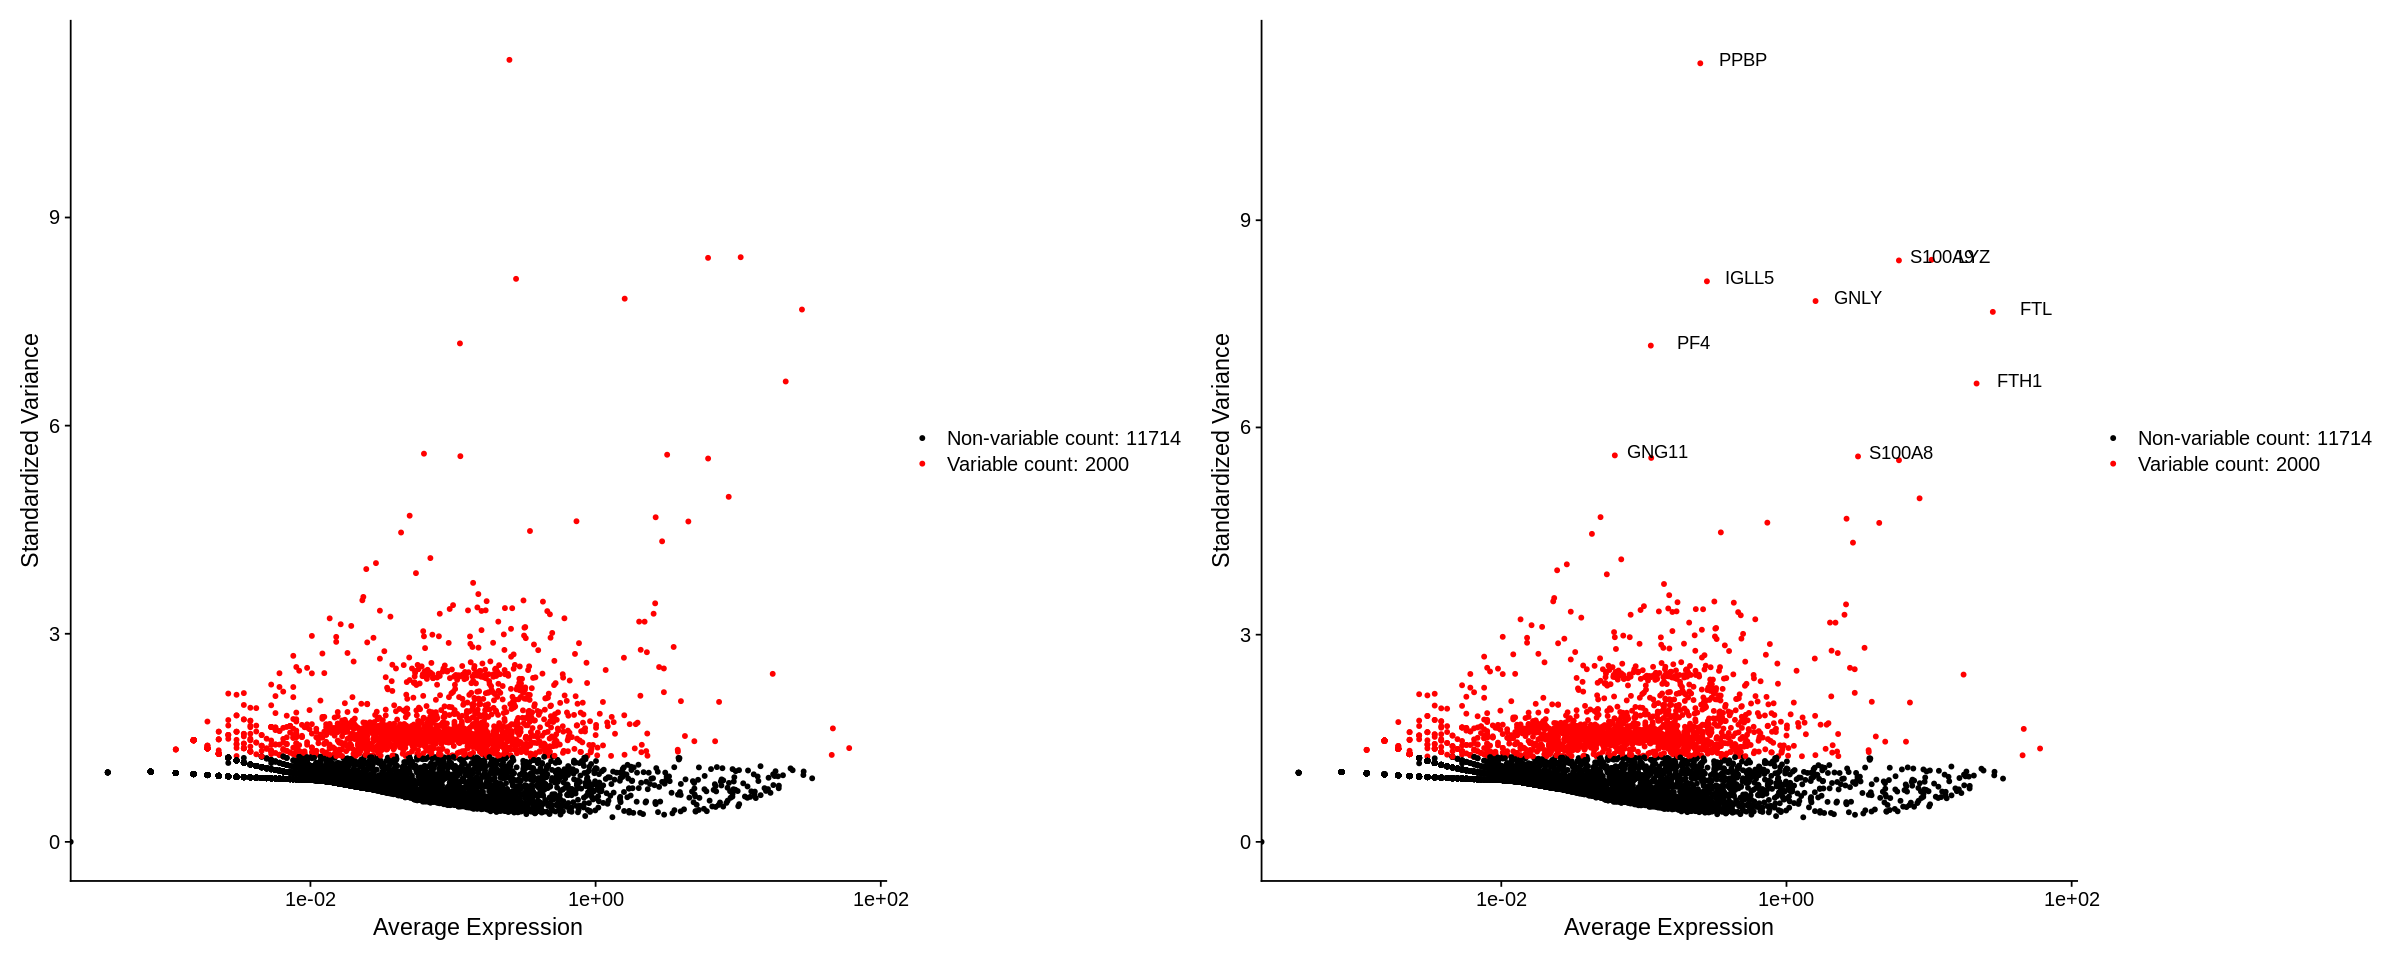

In [ ]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = FALSE)
plot1 + plot2

Let's see the names of the most highly variable genes now

In [ ]:
top10 <- head(VariableFeatures(pbmc), 10)
top10

[1] "PPBP"   "LYZ"    "S100A9" "IGLL5"  "GNLY"   "FTL"    "PF4"    "FTH1"  
 [9] "GNG11"  "S100A8"

##Scaling gene expression
The next step is to scale the expression of each gene to have an average expression over cells of 0 and a variance of 1. This type of linear transformation is commonly applied in many big data domains to allow feautures (eg genes) with different magnitudes (eg expression levels) to contribute equally to downstream analyses. In Seurat, the results of this transformation don't overwrite the unscaled expression values, instead they are stored in sampleA[["RNA"]]@scale.data

In [ ]:
# This is the data matrix before scaling:
pbmc[["RNA"]]$data[1:10,1:20]

  [[ suppressing 20 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



10 x 20 sparse Matrix of class "dgCMatrix"
                                                                   
AL627309.1    . . . . . . . . . . . .        . . . . .        . . .
AP006222.2    . . . . . . . . . . . .        . . . . .        . . .
RP11-206L10.2 . . . . . . . . . . . .        . . . . .        . . .
RP11-206L10.9 . . . . . . . . . . . .        . . . . .        . . .
LINC00115     . . . . . . . . . . . .        . . . . .        . . .
NOC2L         . . . . . . . . . . . 1.646272 . . . . .        . . .
KLHL17        . . . . . . . . . . . .        . . . . .        . . .
PLEKHN1       . . . . . . . . . . . .        . . . . .        . . .
RP11-54O7.17  . . . . . . . . . . . .        . . . . .        . . .
HES4          . . . . . . . . . . . .        . . . . 1.157353 . . .

In [ ]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [ ]:
# The scaled data matrix is not sparse anymore because we substracted the mean:
pbmc[["RNA"]]["scale.data"][1:10,1:20]

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1,AAACGCACTGGTAC-1,AAACGCTGACCAGT-1,AAACGCTGGTTCTT-1,AAACGCTGTAGCCA-1,AAACGCTGTTTCTG-1,AAACTTGAAAAACG-1,AAACTTGATCCAGA-1,AAAGAGACGAGATA-1,AAAGAGACGCGAGA-1,AAAGAGACGGACTT-1,AAAGAGACGGCATT-1,AAAGCAGATATCGG-1,AAAGCCTGTATGCG-1,AAAGGCCTGTCTAG-1,AAAGTTTGATCACG-1
AL627309.1,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316,-0.05812316
AP006222.2,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571,-0.03357571
RP11-206L10.2,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819,-0.04166819
RP11-206L10.9,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562,-0.03364562
LINC00115,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981,-0.08223981
NOC2L,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,2.94525463,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081,-0.31717081
KLHL17,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722,-0.05344722
PLEKHN1,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183,-0.05082183
RP11-54O7.17,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805,-0.03308805
HES4,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,-0.23376818,2.81300290,-0.23376818,-0.23376818,-0.23376818


# Dimension reduction with PCA

In [ ]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

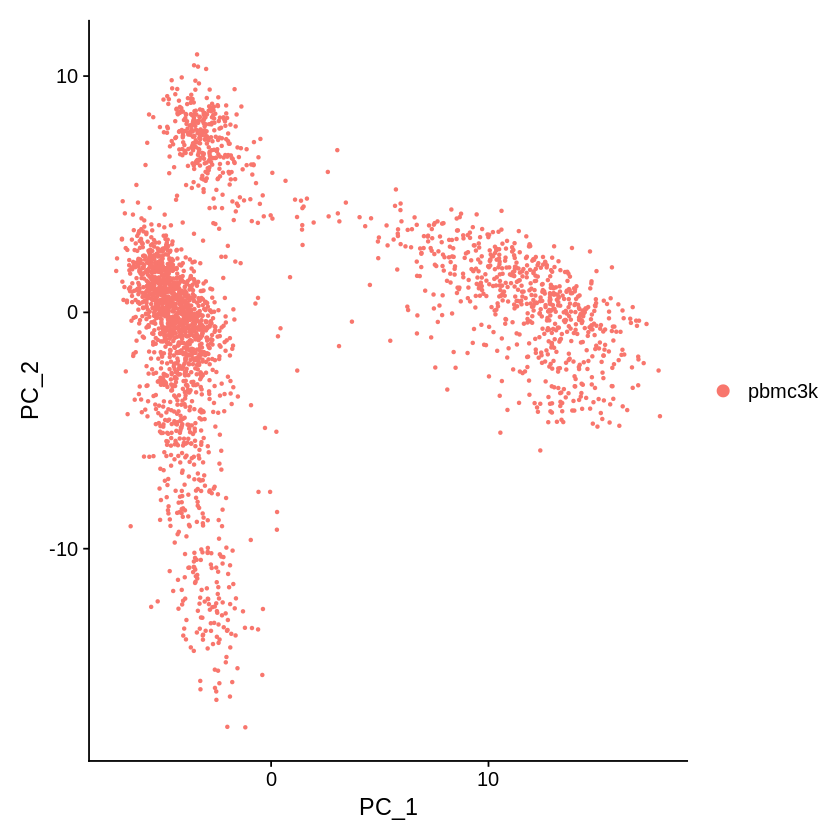

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(pbmc, reduction = "pca")

Let's look at gene expression across one of these compressed dimensions, PC1. Every cell is a column and every gene is a row:

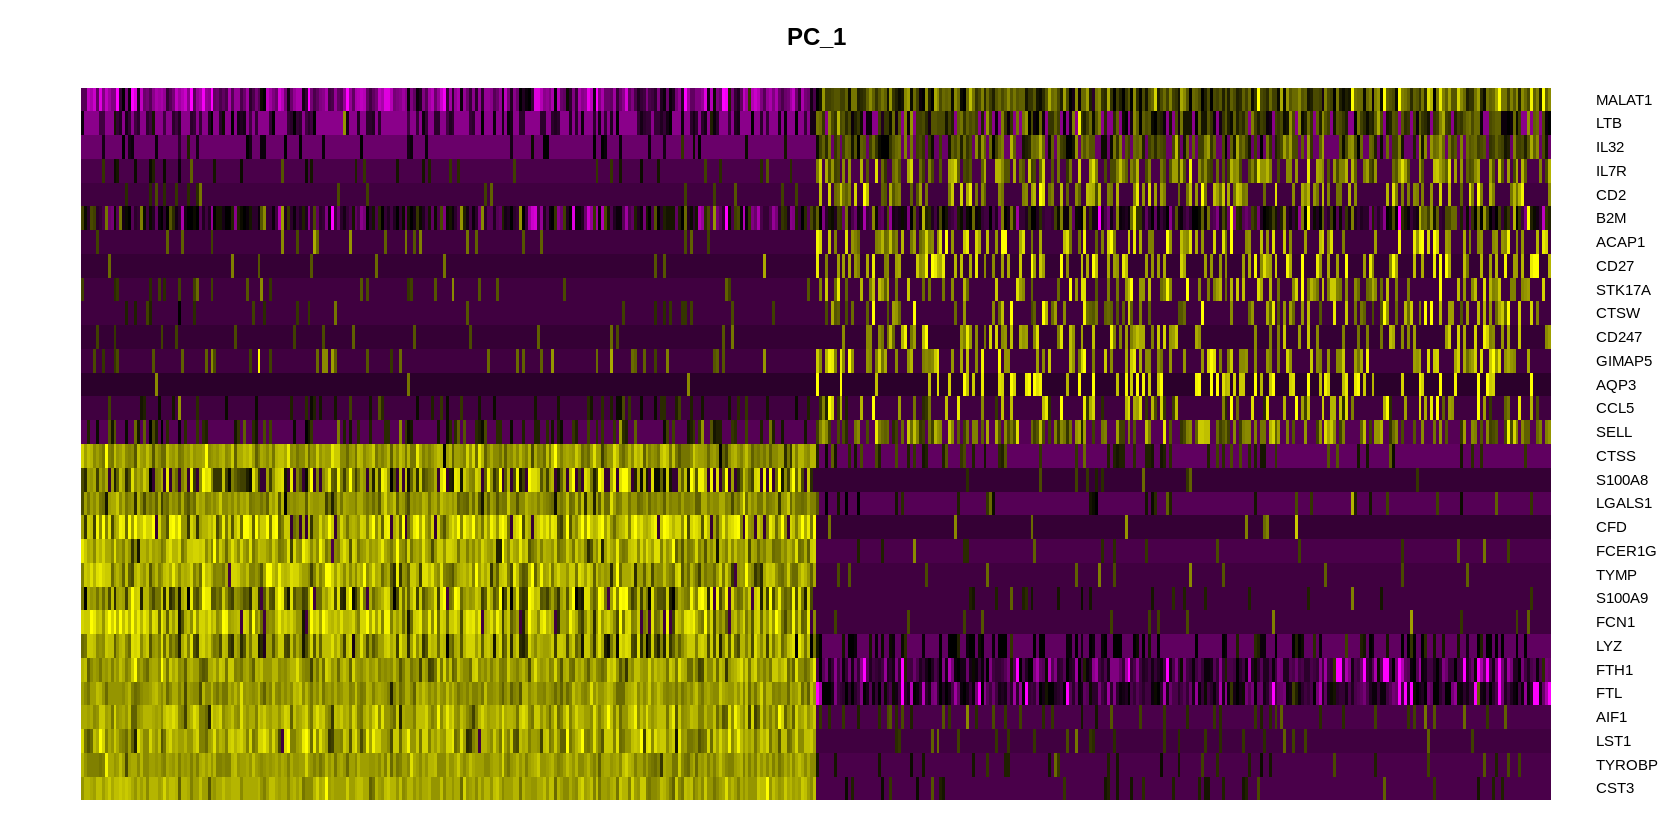

In [ ]:
options(repr.plot.width=14, repr.plot.height=7)
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

The scatterplot and the heatmap show that we can already look at basic trends in the dataset with PCA. Next, we will use the PCA for clustering and UMAP computation to obtain more information about cell subsets and gene expression trends.

# Cluster the cells

This clustering groups similar cells into "clusters".

In [ ]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


# UMAP

UMAP is a dimension reduction that is specialized to pack all information on cells into 2 dimensions so that you can view global structure of the dataset (e.g cell type groups) in a scatter plot.

In [ ]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:39:06 UMAP embedding parameters a = 0.9922 b = 1.112

12:39:06 Read 2638 rows and found 10 numeric columns

12:39:06 Using Annoy for neighbor search, n_neighbors = 30

12:39:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:39:07 Writing NN index file to temp file /tmp/RtmpaRcs2c/filee8791c207

12:39:07 Searching Annoy index using 1 thread, search_k = 3000

12:39:08 Annoy recall = 100%

12:39:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

Now, we can plot the scatterplot in which each point is a cell, that has UMAP coordinates. In color, we superimpose cluster labels from the previous section. Note that clusters separate out in the UMAP, which is expected.

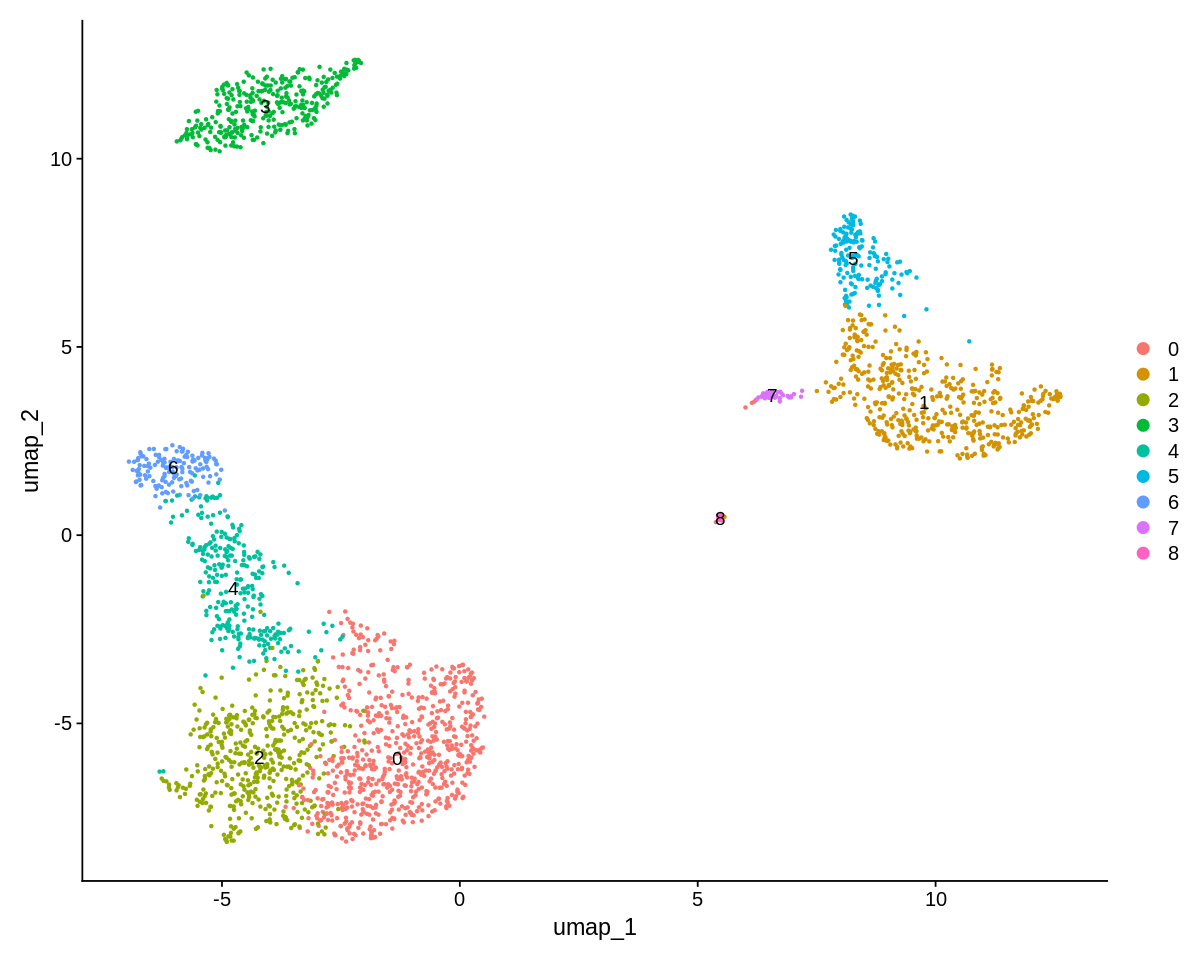

In [ ]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(pbmc, reduction = "umap",label=TRUE)

# Finding differentially expressed features (cluster biomarkers)

Next, we'll find genes that differ strongly in their expression between clusters of cells. These are "marker genes" or "differentially expressed genes" and are useful to identify which cluster is which cell type.

In [ ]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A8,0.000000e+00,6.642881,0.975,0.121,0.000000e+00
LGALS2,0.000000e+00,5.628925,0.908,0.059,0.000000e+00
FCN1,0.000000e+00,4.058240,0.952,0.151,0.000000e+00
S100A9,0.000000e+00,6.177616,0.996,0.215,0.000000e+00
CD14,2.856582e-294,5.944747,0.667,0.028,3.917516e-290


In [ ]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.150929e-209,6.832372,0.975,0.039,2.949784e-205
IFITM3,6.103366e-199,6.181000,0.975,0.048,8.370156e-195
CFD,8.891428e-198,6.052575,0.938,0.037,1.219370e-193
CD68,2.374425e-194,5.493138,0.926,0.035,3.256286e-190
RP11-290F20.3,9.308287e-191,6.335402,0.840,0.016,1.276538e-186


In [ ]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.167632e-83,2.369020,0.435,0.108,1.601290e-79,0,CCR7
3.284150e-49,2.096128,0.333,0.103,4.503883e-45,0,LEF1
3.098695e-139,7.284513,0.300,0.004,4.249550e-135,1,FOLR3
1.625903e-121,6.741401,0.277,0.006,2.229763e-117,1,S100A12
2.610017e-59,2.108140,0.424,0.111,3.579377e-55,2,AQP3
1.941642e-35,1.901907,0.267,0.069,2.662768e-31,2,CD40LG
2.397625e-272,7.379757,0.564,0.009,3.288103e-268,3,LINC00926
2.745016e-237,7.135051,0.488,0.007,3.764515e-233,3,VPREB3
4.932509e-169,4.366254,0.595,0.056,6.764443e-165,4,GZMK


In [ ]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

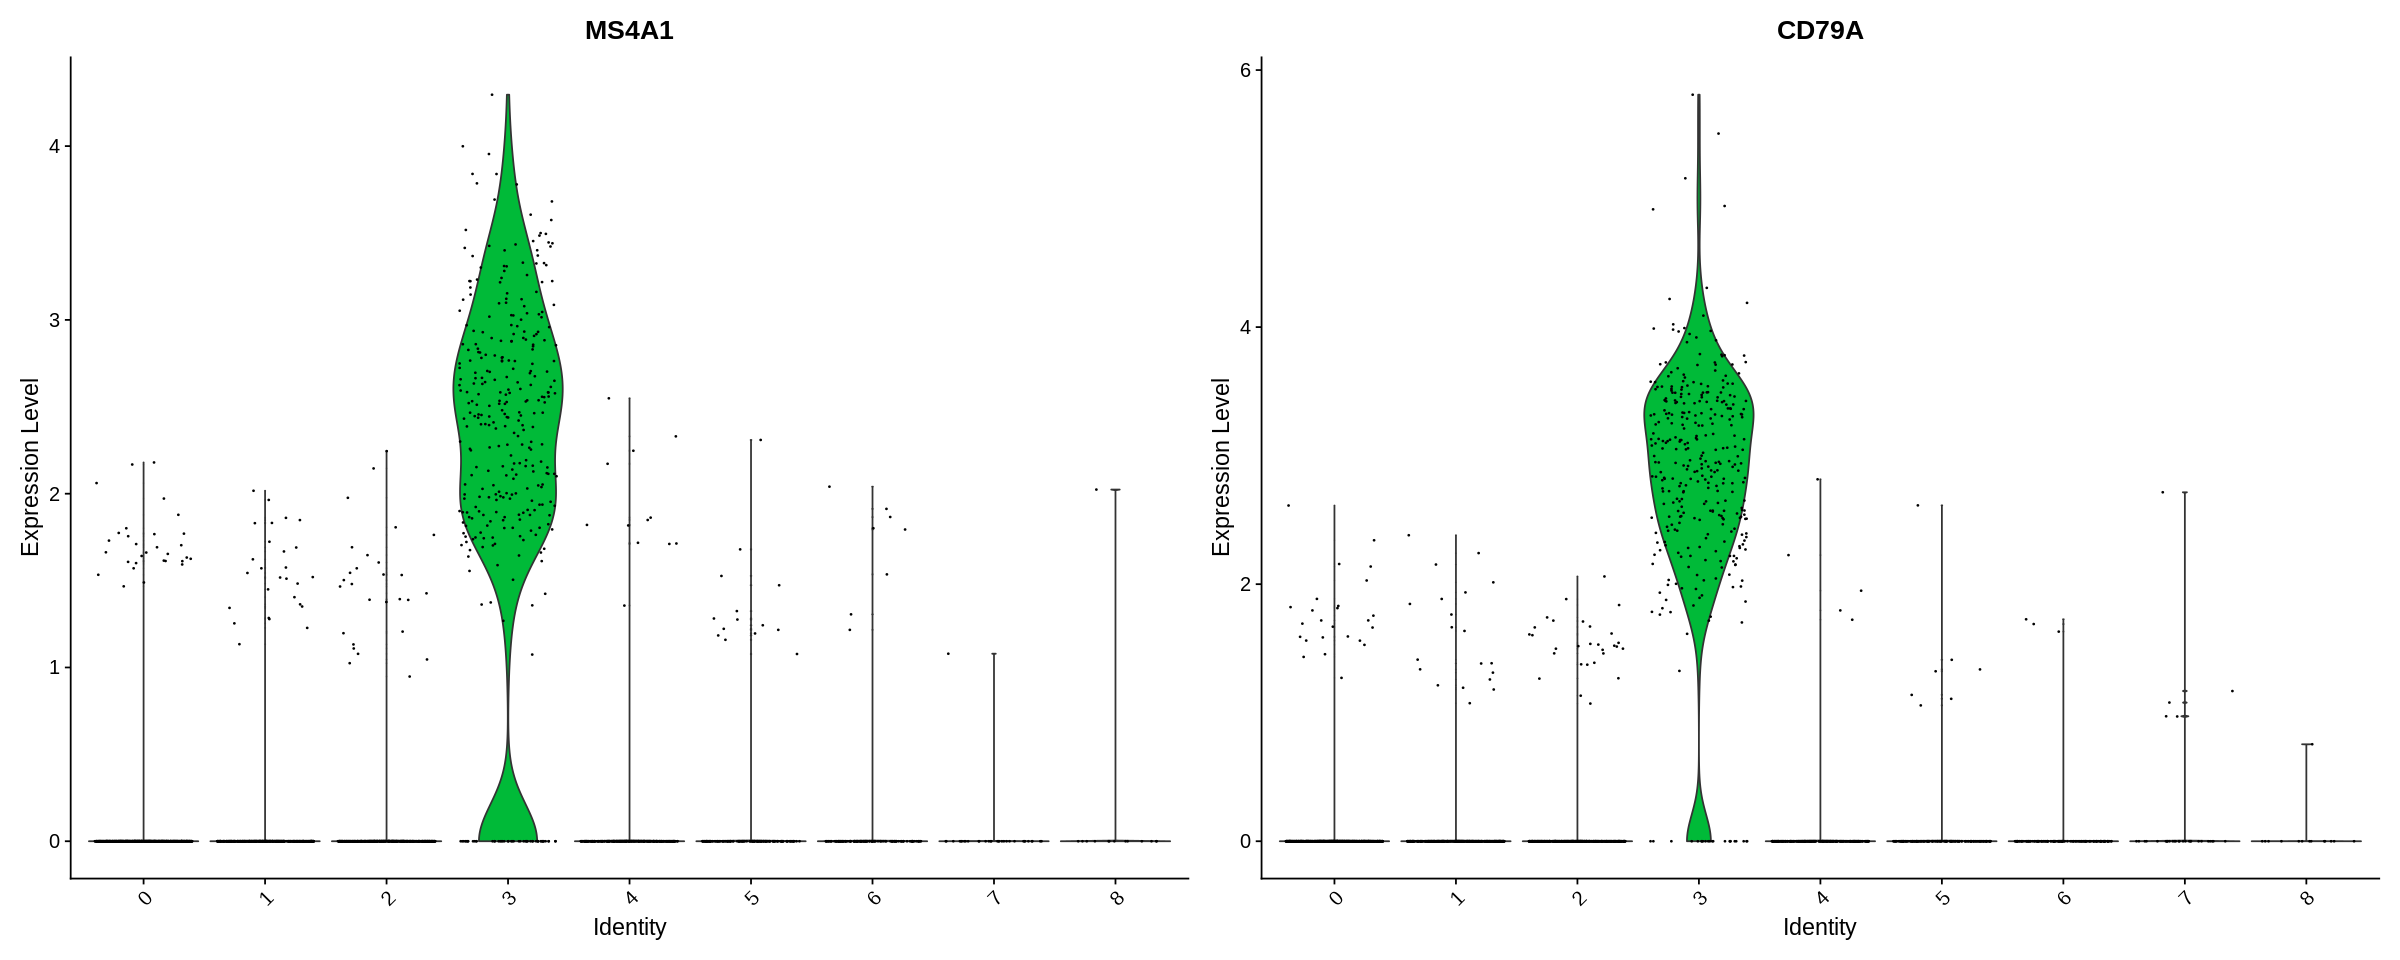

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

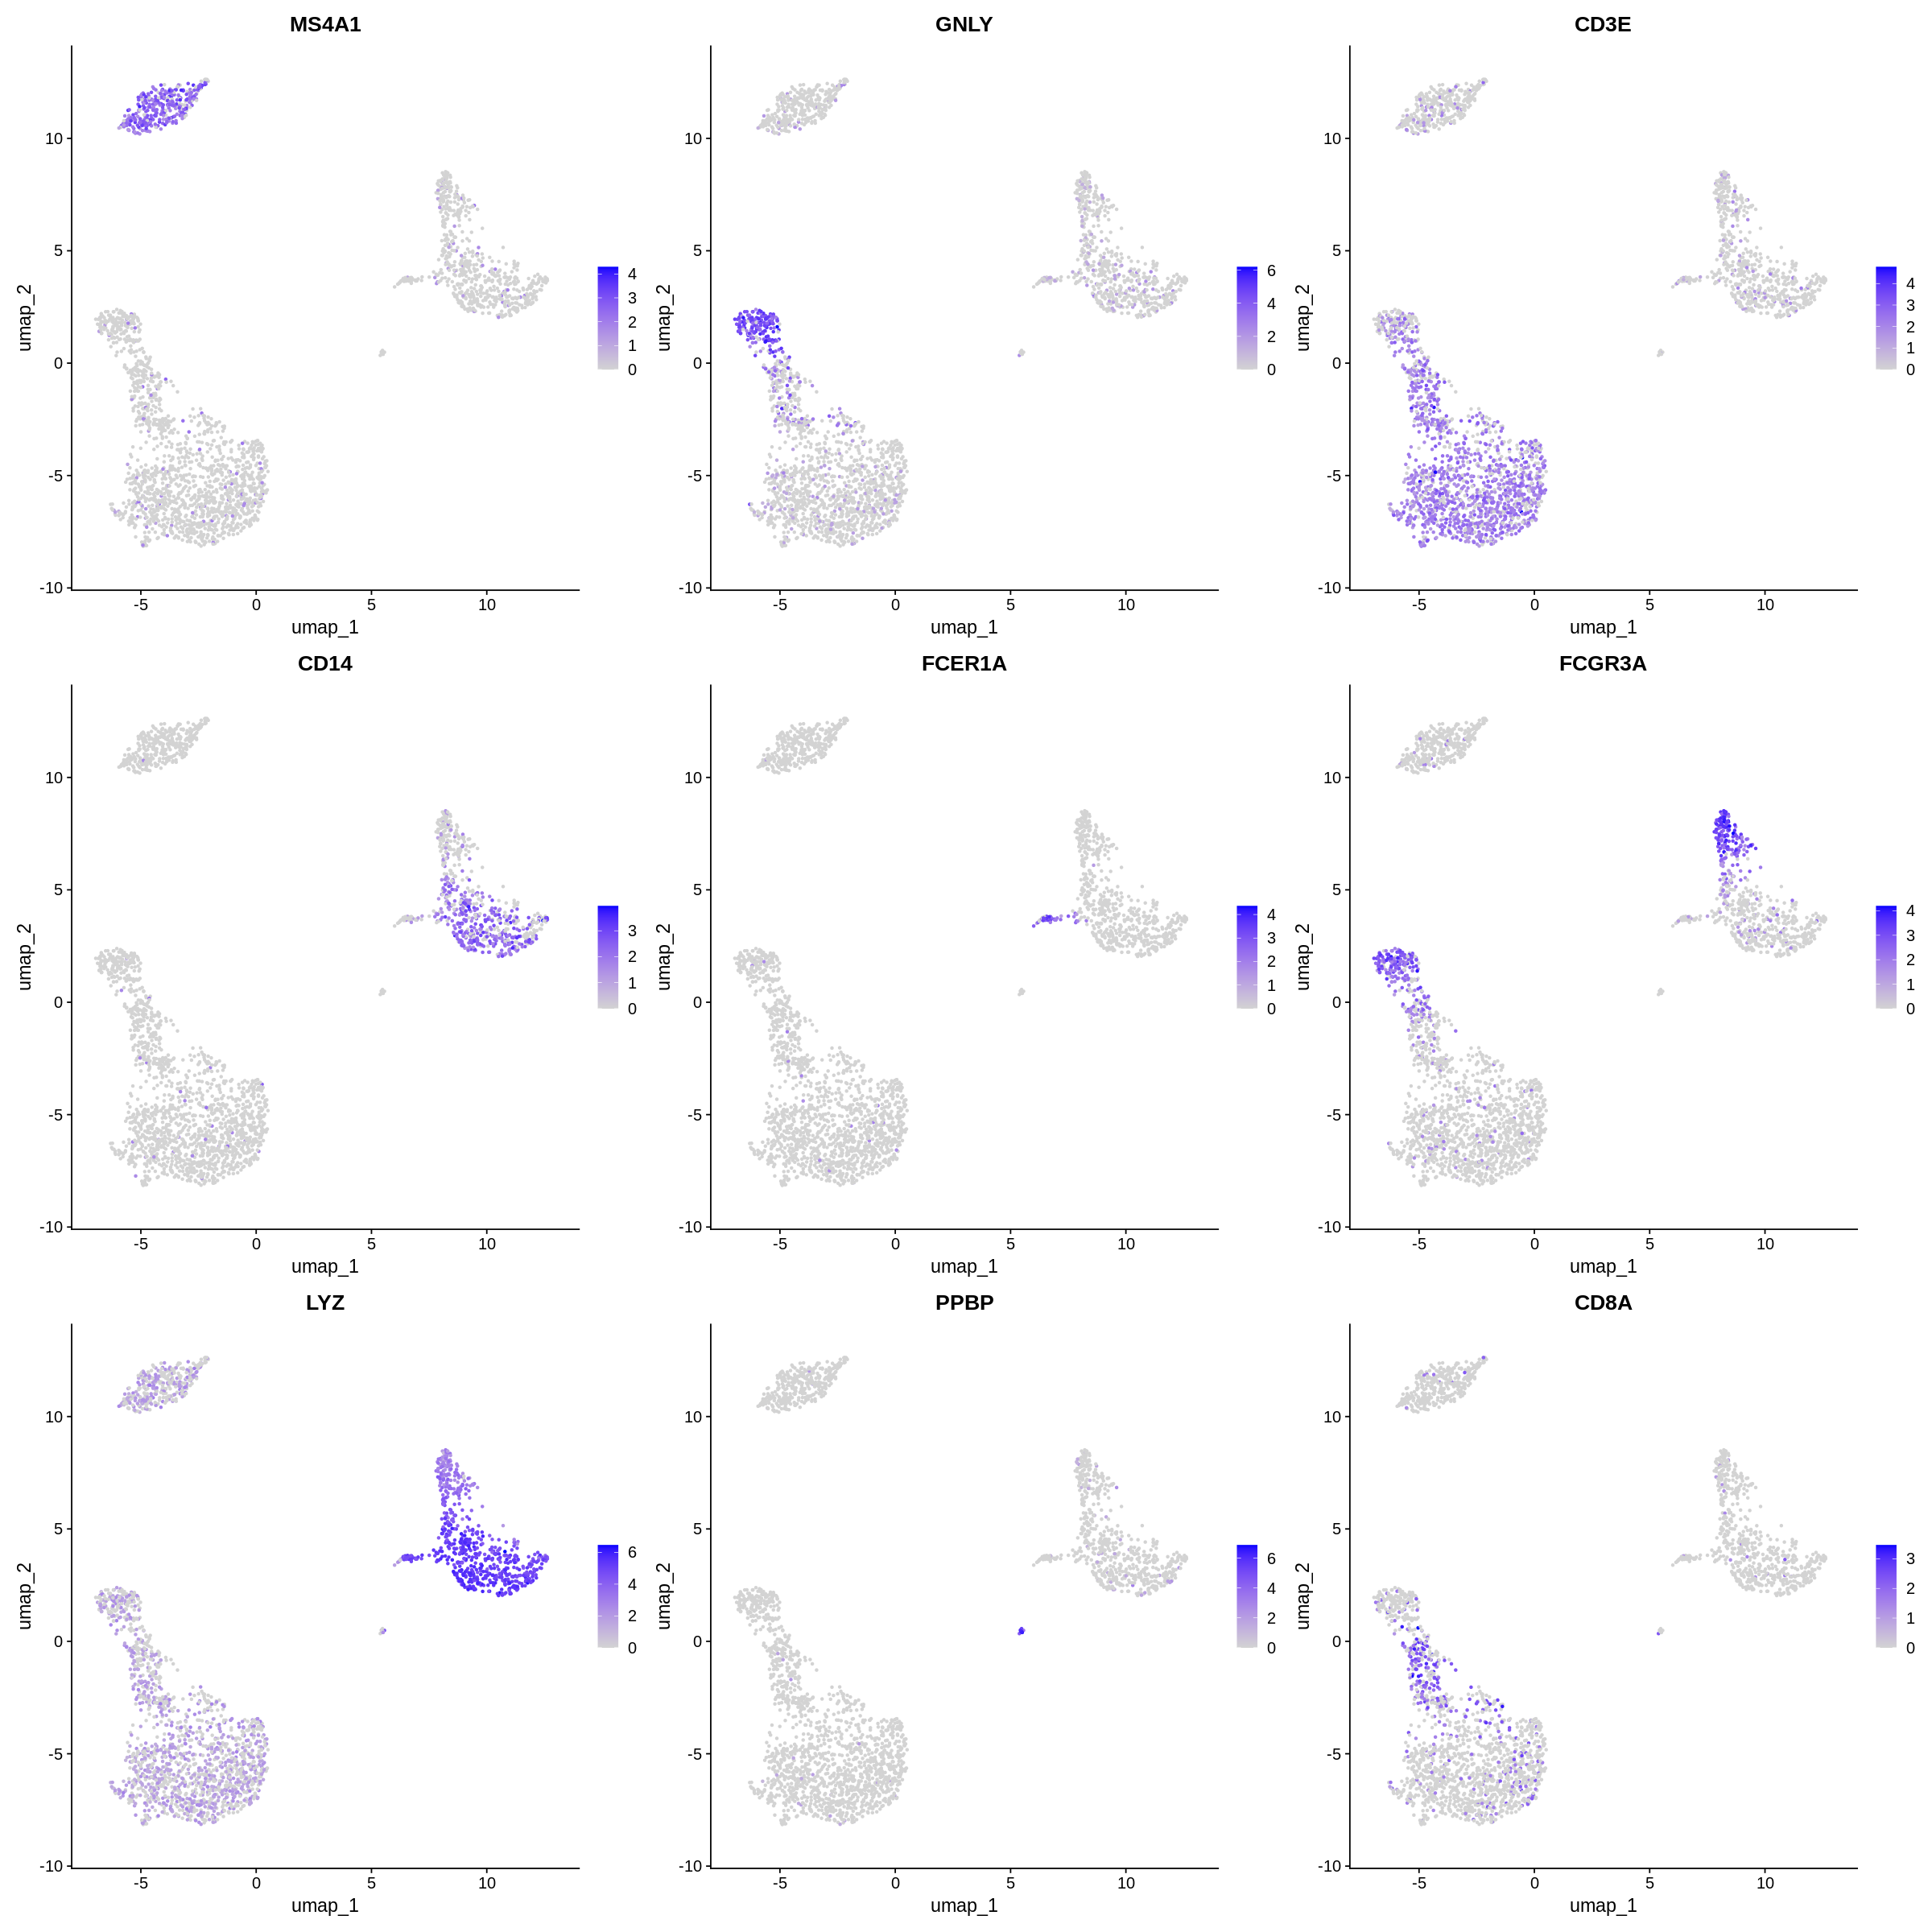

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
FeaturePlot(pbmc, features = c(
  "MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

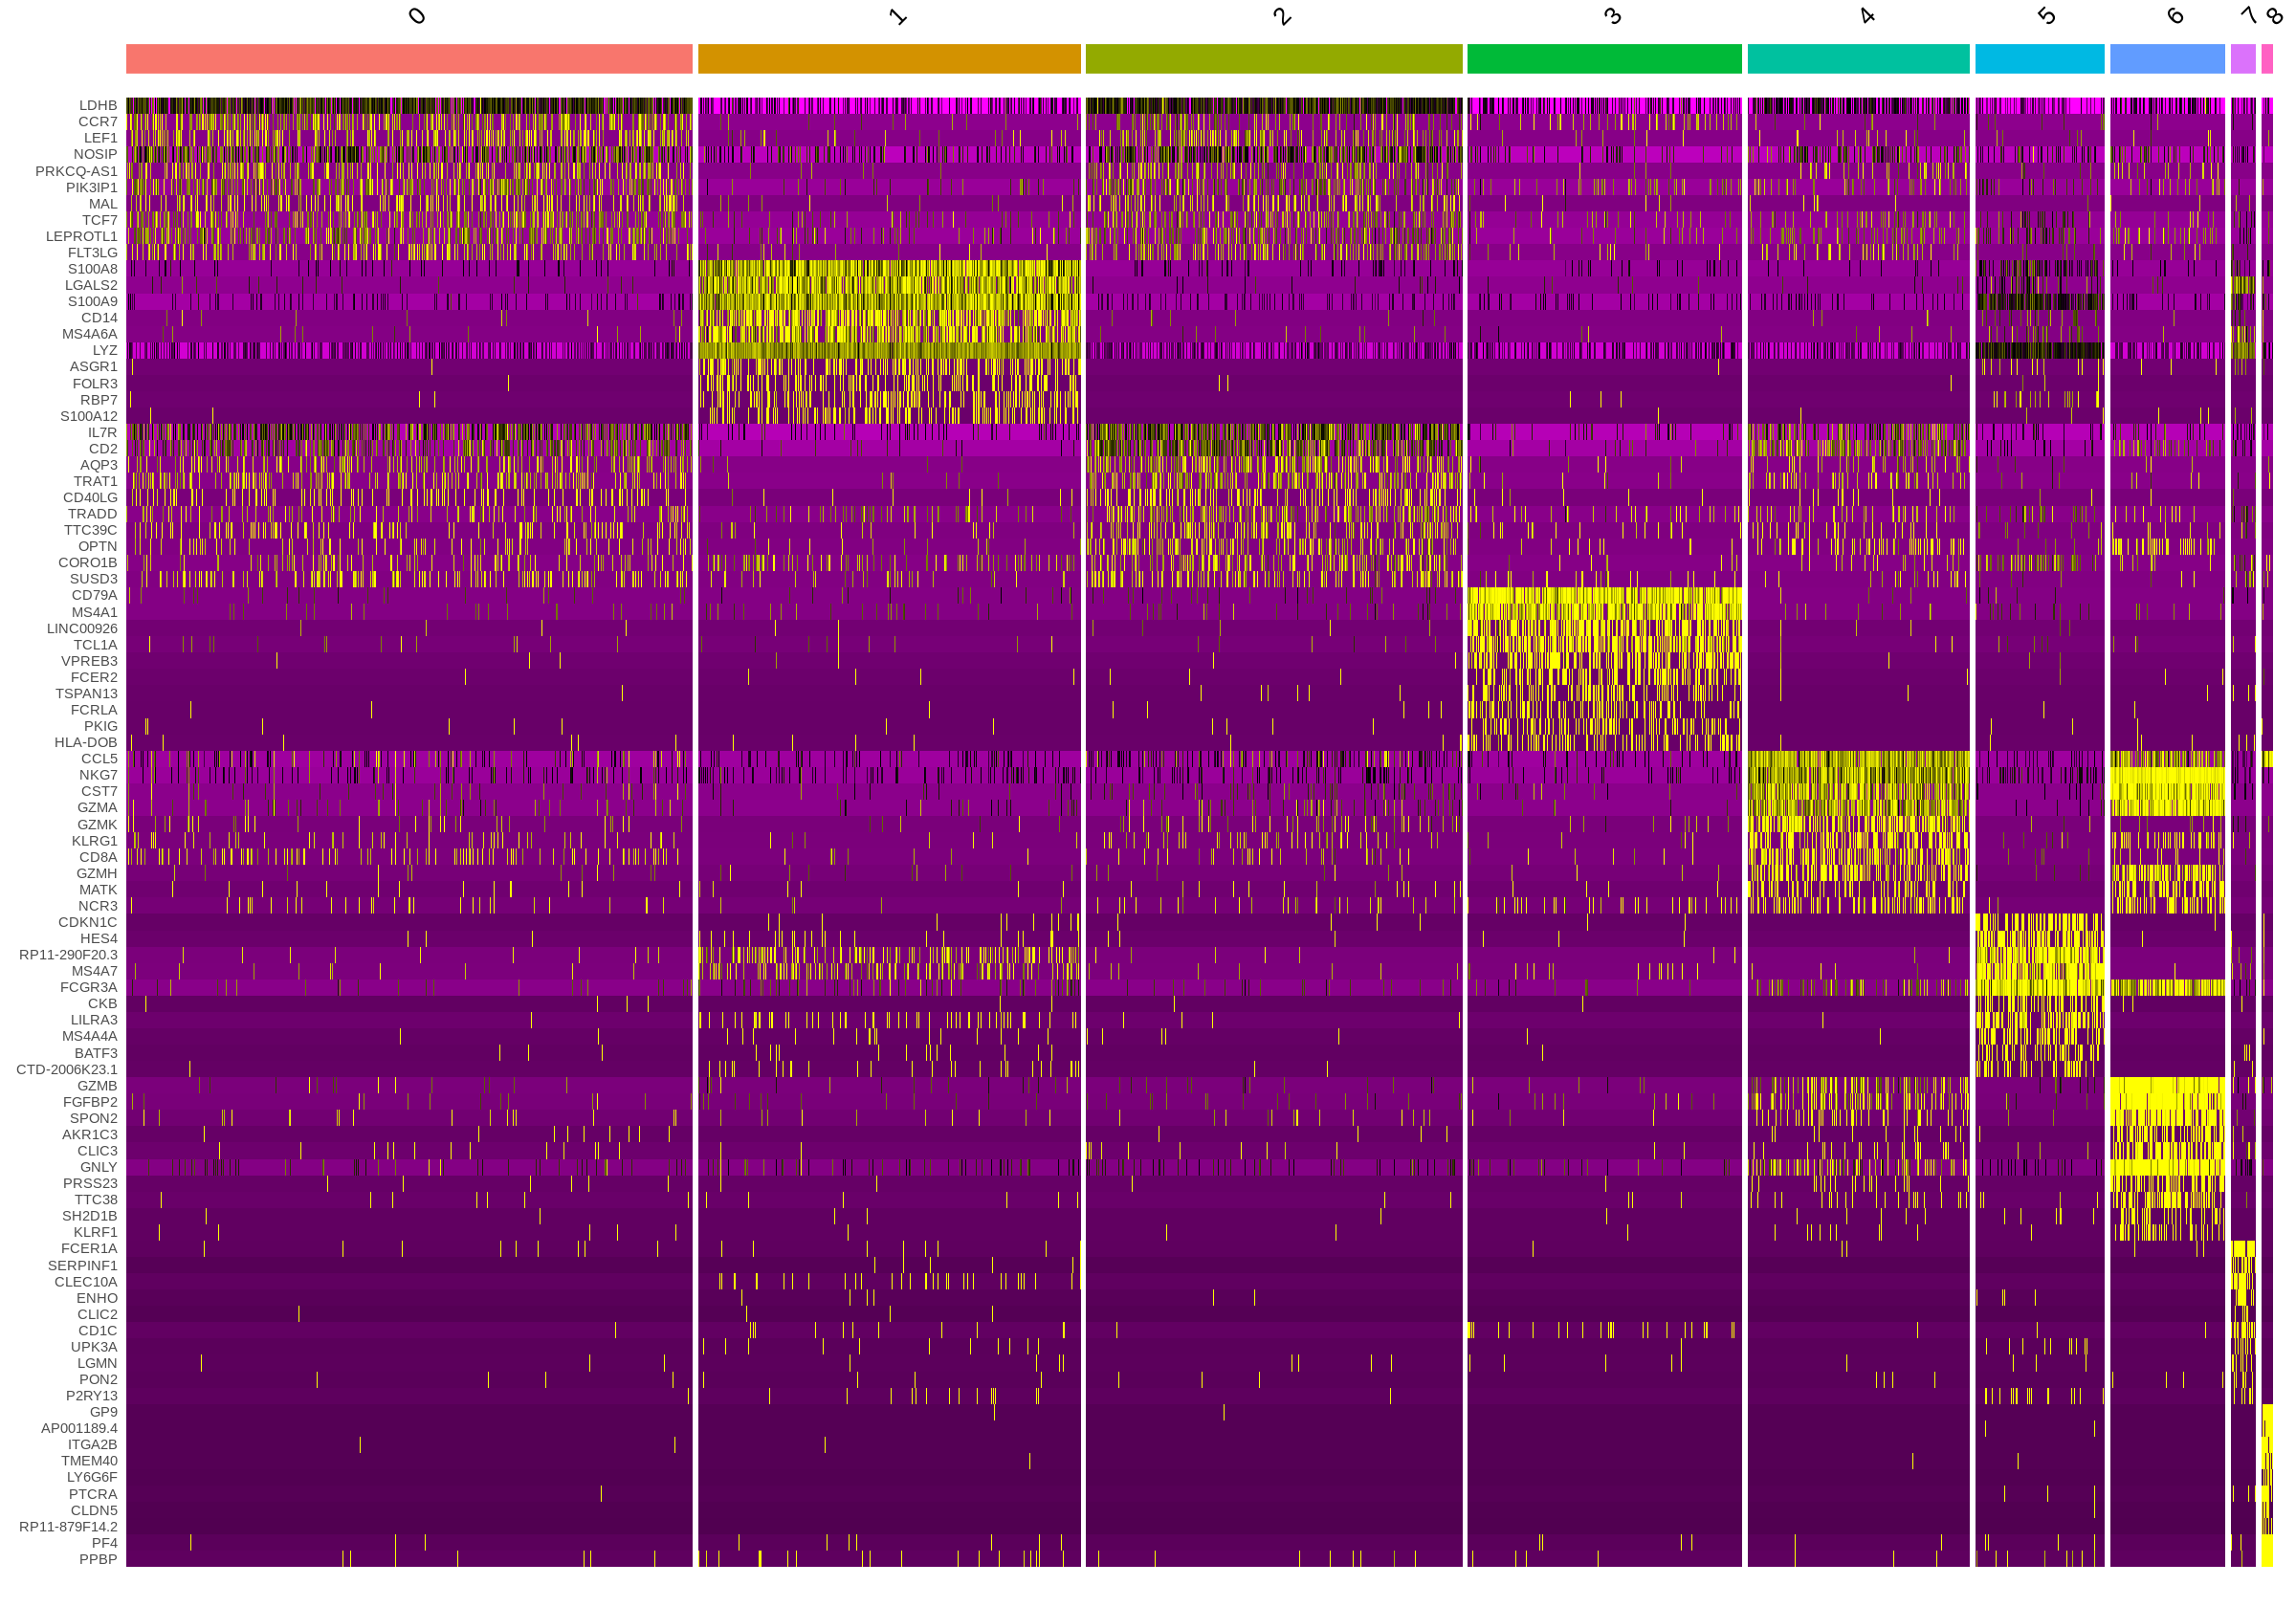

In [ ]:
options(repr.plot.width=20, repr.plot.height=14)
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

# Assigning cell type identity to clusters

We abbreviated this section, here, you would use the marker genes above to map each cluster to a cell type. We can then replace the numeric cluster names by cell type labels and plot these on the UMAP.

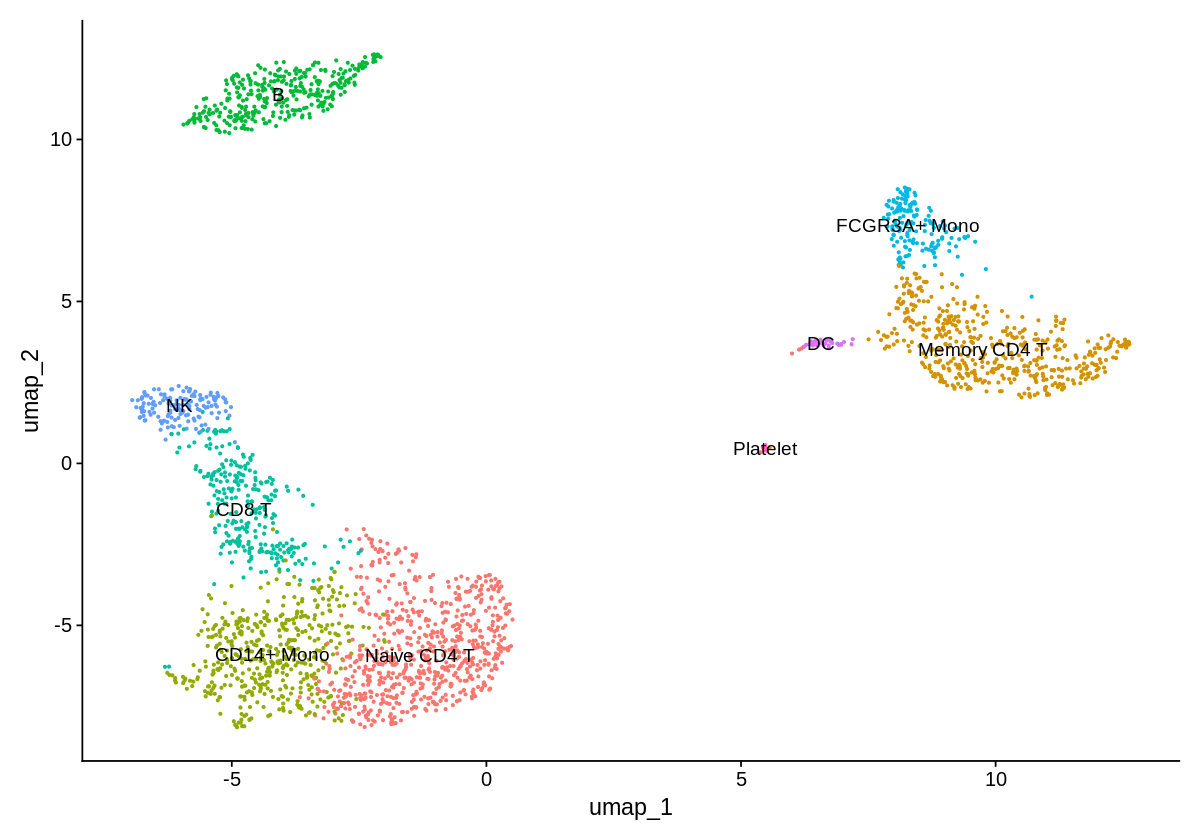

In [ ]:
options(repr.plot.width=10, repr.plot.height=7)
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()